# ML SVM Access Control Scenarios

Using CrypTen to carry out private computations in some common use cases. 
In the following scenarios, we'll use a simple two-party setting and demonstrate how we can learn a linear SVM on private data and see how access control works in CrypTen MPC.

### Use the ***crypten*** kernel and conda environment

### Resources
https://en.wikipedia.org/wiki/Support_vector_machine<br />
https://www.geeksforgeeks.org/classifying-data-using-support-vector-machinessvms-in-python/<br />
https://www.mltut.com/svm-implementation-in-python-from-scratch/<br />
https://innovationyourself.com/svm-classifier-in-python/<br />
https://www.geeksforgeeks.org/two-dimensional-tensors-in-pytorch/<br />
https://pytorch.org/docs/stable/tensors.html

## What is Linear SVM
Images from https://www.mltut.com/svm-implementation-in-python-from-scratch/<br />
Linear SVM ( Support Vector Machine) is a supervised machine learning classification algorithm.<br />
A binary classification algorithm to classify data points into two distinct classes using a decision boundary and support vectors.<br />

<nop/> <div style="width: 500px;">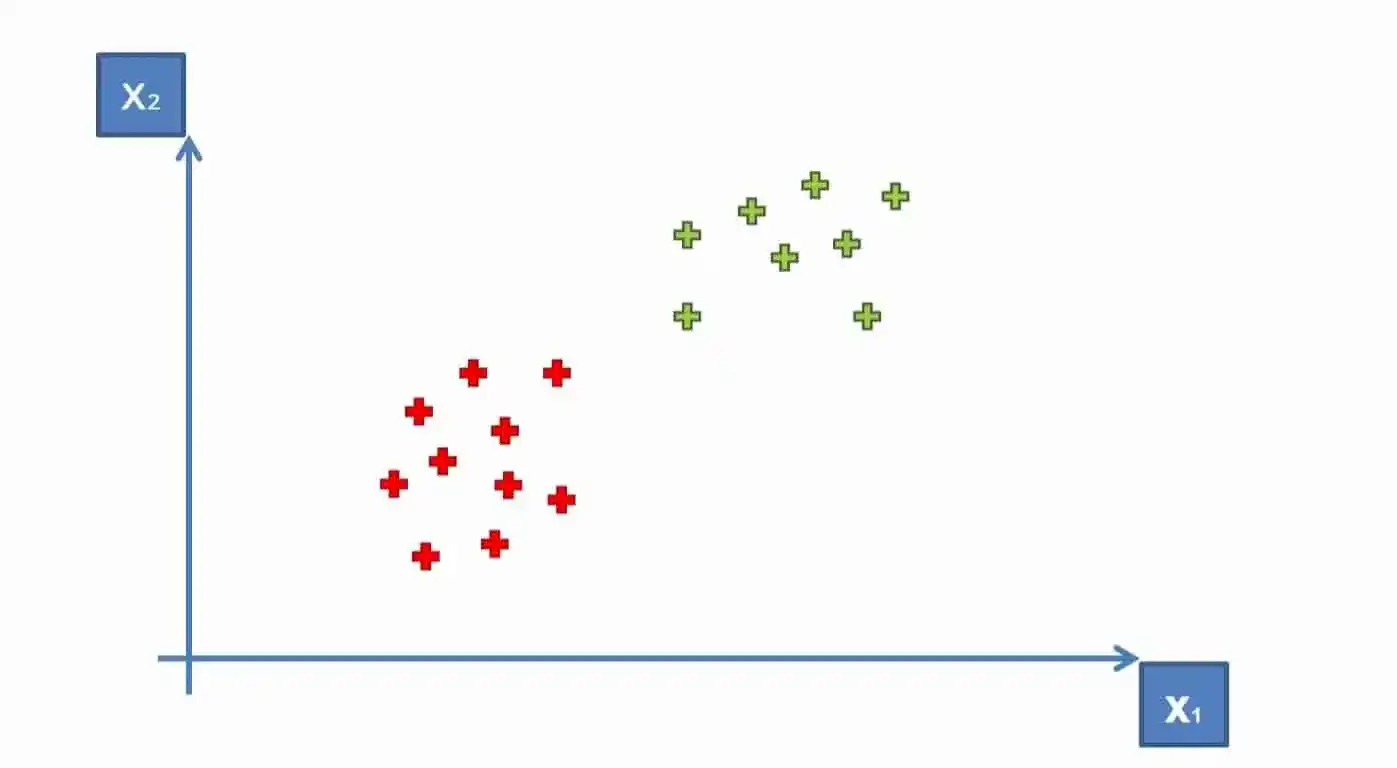</div>
Example: two columns x1 and x2 of observations, which are already classified (red and green). This is linearly separable data.

To classify future points, we need to create a boundary between two categories, and according to a point's place in regard to the boundary, we can classify it either as Green or Red. <br />
SVM is used to find the optimal hyperplane that maximizes the margin between the two classes while minimizing classification errors.<br />

<nop/> <div style="width: 500px;">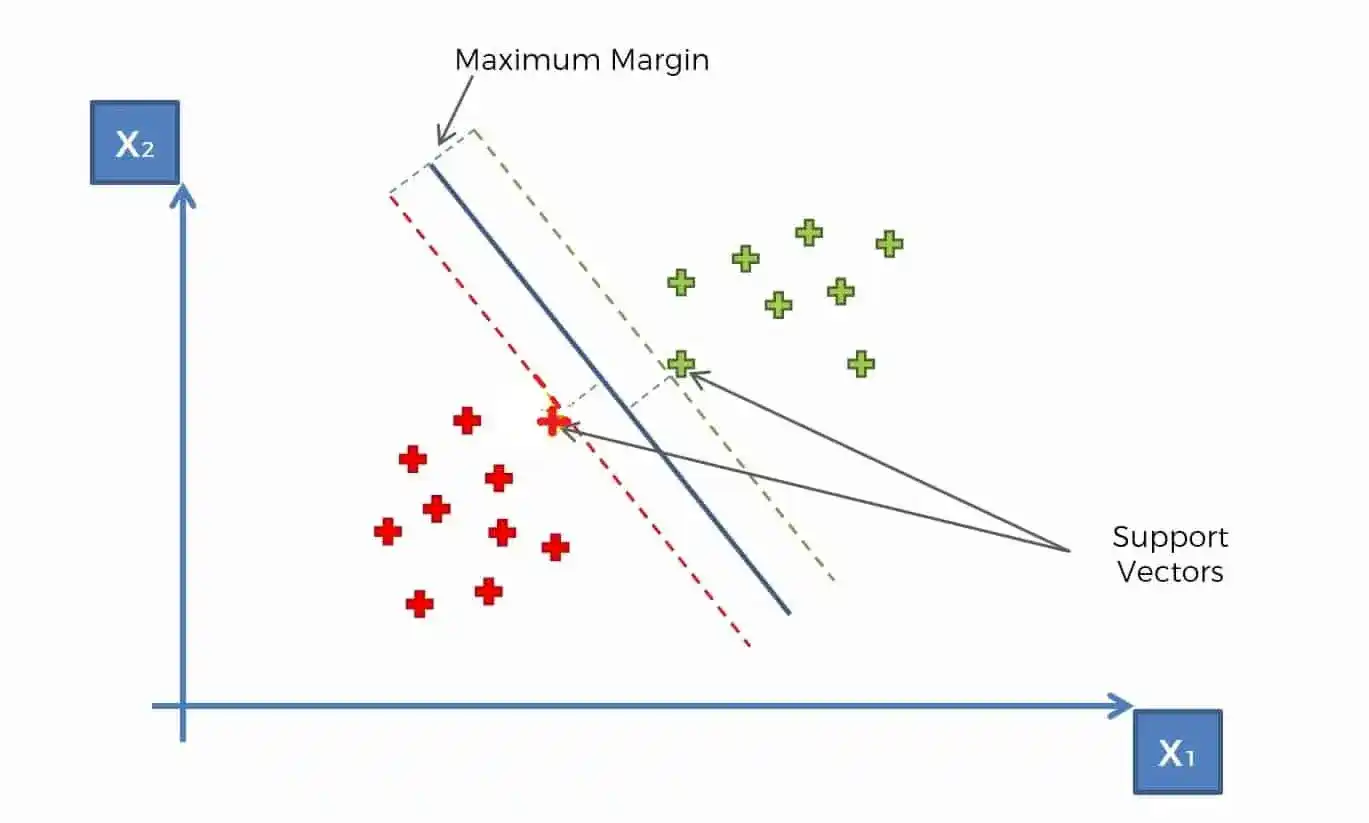</div>
SVM uses two supporting vectors to calculate the distance between the supporting vectors and the hyperplane. <br />
The middle line is a maximum margin hyperplane or classifier.  <br />
In a two-dimensional plane, it is a line, but in a multi-dimensional, it is a hyperplane.<br />
The hyperplane acts as the decision boundary, allowing SVM to make accurate predictions on new, unseen data.

A simplified version of the equation for a hyperplane:

$w.x + b = 0$

(*w*) The weight vector, representing the direction of the hyperplane.<br />
(*x*) The feature vector for a data point.<br />
(*b*) The bias term.

SVM has to find the (*w*) and (*b*) values that maximize the margin between the closest data points (support vectors) of the two classes. <br />
This optimization problem can be formulated as a quadratic programming problem, which various machine learning libraries (such as Scikit-Learn), solve efficiently.

In [1]:
!pwd

/home/ubuntu/workspace/orivlin.confidential_computing_class/mpc_demo


In [2]:
!pip install -r requirements.examples.txt --quiet

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
import crypten
import torch

crypten.init()
torch.set_num_threads(1)

## Setup
Train a Linear SVM to perform binary classification. <br />

Generate 1000 ground truth samples using 100 features and a randomly generated hyperplane to separate positive and negative examples.  <br />

(Note: this will cause the classes to be linearly separable, so a linear SVM will be able to classify with perfect accuracy given the right parameters.)  <br />

Include a test set of examples (that are also linearly separable by the same hyperplane) to show that the model learns a general hyperplane rather than memorizing the training data.

In [5]:
num_features = 100
num_train_examples = 1000
num_test_examples = 100
epochs = 40
lr = 3.0

"""
Class torch.Tensor:
https://pytorch.org/docs/stable/tensors.html
"""

# Set random seed for reproducibility
torch.manual_seed(1)

# features: 1000 item examples with 100 features per item
features = torch.randn(num_features, num_train_examples)

# weights: a weight per feature (matrix of 1x100)
w_true = torch.randn(1, num_features)

# bias: scalar
b_true = torch.randn(1)

# labels: target labels, one per example item
# an additional column (101) as target labels
# sign() returns a new tensor with the signs of the elements of input.
labels = w_true.matmul(features).add(b_true).sign()

test_features = torch.randn(num_features, num_test_examples)
test_labels = w_true.matmul(test_features).add(b_true).sign()

print(r"𝑤.𝑥+𝑏=0")
print(f"\nweights shape:\n {w_true.shape}")
print(f"\nweights:\n {str(w_true[:,:5])}")
print(f"\nbias shape:\n {b_true.shape}")
print(f"\nbias:\n {b_true}")
print(f"\nfeatures of examples shape:\n {features.shape}")
print(f"\nfeatures[0] of examples:\n {features[0,:5]}")
print(f"\nfeatures[1] of examples:\n {features[1,:5]}")
print(f"\nlabels of examples shape:\n {labels.shape}")
print(f"\nlabels of examples:\n {labels[0,:10]}")

𝑤.𝑥+𝑏=0

weights shape:
 torch.Size([1, 100])

weights:
 tensor([[-1.0072,  0.4570, -0.0383,  2.7769,  0.9118]])

bias shape:
 torch.Size([1])

bias:
 tensor([-1.8686])

features of examples shape:
 torch.Size([100, 1000])

features[0] of examples:
 tensor([-1.5256, -0.7502, -0.6540, -1.6095, -0.1002])

features[1] of examples:
 tensor([1.1658, 0.1701, 0.5288, 2.8891, 0.1601])

labels of examples shape:
 torch.Size([1, 1000])

labels of examples:
 tensor([-1., -1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.])


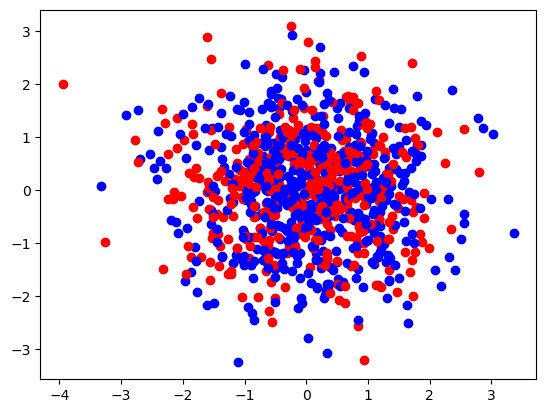

In [6]:
# create scatter plot for samples from each label class
x = features[0,:] # examples dimension index 0
y = features[1,:] # examples dimension index 1
for i in range(len(features.data[0,:])):
    #print(labels[0,i])
    if labels[0,i] == 1.:
        plt.scatter(features[0,i], features[1,i], c='r')
    else:
        plt.scatter(features[0,i], features[1,i], c='b')
# show the plot
plt.show()

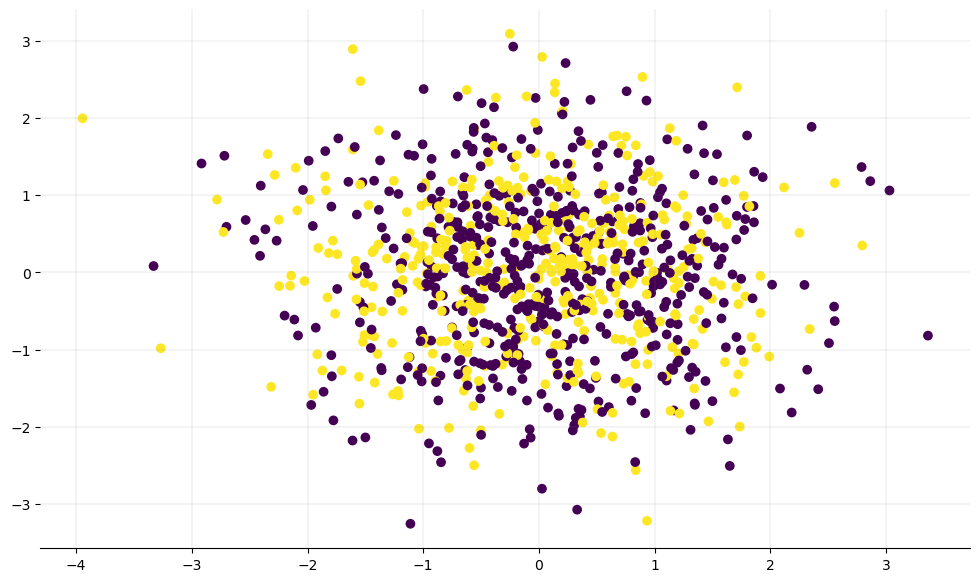

In [7]:
# Plotting the training set
fig, ax = plt.subplots(figsize=(12, 7))
# removing to and right border
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
# adding major gridlines
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax.scatter(features[0,:], features[1,:], c=labels) # color="#8C7298")
plt.show()

[]

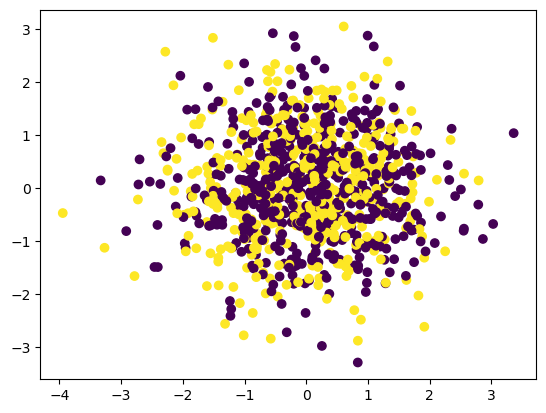

In [8]:
# ISLP.svm.plot(features, labels, 'SVM')
#plt.figure(figsize=(8, 6))
plt.scatter(features.data[0,:], features.data[-1,:], c=labels)
plt.plot()

Now that we have generated our dataset, we will train our SVM in four different access control scenarios across two parties, Alice and Bob:

- Data Labeling: Alice has access to features, while Bob has access to labels
- Feature Aggregation: Alice has access to the first 50 features, while Bob has access to the last 50 features
- Data Augmentation: Alice has access to the first 500 examples, while Bob has access to the last 500 examples
- Model Hiding: Alice has access to `w_true` and `b_true`, while Bob has access to data samples to be classified

Throughout this tutorial, we will assume Alice is using the rank 0 process, while Bob is using the rank 1 process. Additionally we will initialize our weights using random values.

In [9]:
ALICE = 0
BOB = 1

In each example, we will use the same code to train our linear SVM once the features and labels are properly encrypted. This code is contained in `examples/mpc_linear_svm`, but it is unnecessary to understand the training code to properly use access control. The training process itself is discussed in depth in later tutorials.


In [10]:
# from examples.mpc_linear_svm.mpc_linear_svm import train_linear_svm, evaluate_linear_svm
from mpc_linear_svm.mpc_linear_svm import train_linear_svm, evaluate_linear_svm

## Saving / Loading Data

We have now generated features and labels for our model to learn. In the scenarios we explore in this tutorial, we would like to ensure that each party only has access to some subset of the data we have generated. To do so, we will use special save / load methods that CrypTen provides to handle loading only to a specified party and synchronizing across processes. 

We will use `crypten.save_from_party()` here to save data from a particular source, then we will load using `crypten.load()` in each example to load on a particular source. The following code will save all data we will use to files, then each example will load its data as necessary.

(Note that because we are operating on a single machine, all processes will have access to all of the files we are using. However, this still will work as expected when operating across machines.)

In [11]:
from crypten import mpc

# Specify file locations to save each piece of data
filenames = {
    "features": "tmp/features.pth",
    "labels": "tmp/labels.pth",
    "features_alice": "tmp/features_alice.pth",
    "features_bob": "tmp/features_bob.pth",
    "samples_alice": "tmp/samples_alice.pth",
    "samples_bob": "tmp/samples_bob.pth",
    "w_true": "tmp/w_true.pth",
    "b_true": "tmp/b_true.pth",
    "test_features": "tmp/test_features.pth",
    "test_labels": "tmp/test_labels.pth",
}


@mpc.run_multiprocess(world_size=2)
def save_all_data():
    # Save features, labels for Data Labeling example
    crypten.save_from_party(features, filenames["features"])
    crypten.save_from_party(labels, filenames["labels"])
    
    # Save split features for Feature Aggregation example
    features_alice = features[:50]
    features_bob = features[50:]
    
    crypten.save_from_party(features_alice, filenames["features_alice"], src=ALICE)
    crypten.save_from_party(features_bob, filenames["features_bob"], src=BOB)
    
    # Save split dataset for Dataset Aggregation example
    samples_alice = features[:, :500]
    samples_bob = features[:, 500:]
    crypten.save_from_party(samples_alice, filenames["samples_alice"], src=ALICE)
    crypten.save_from_party(samples_bob, filenames["samples_bob"], src=BOB)
    
    # Save true model weights and biases for Model Hiding example
    crypten.save_from_party(w_true, filenames["w_true"], src=ALICE)
    crypten.save_from_party(b_true, filenames["b_true"], src=ALICE)
    
    crypten.save_from_party(test_features, filenames["test_features"], src=BOB)
    crypten.save_from_party(test_labels, filenames["test_labels"], src=BOB)
    
save_all_data()

[None, None]

## Scenario 1: Data Labeling

Our first example will focus on the <i>Data Labeling</i> scenario. In this example, Alice has access to features, while Bob has access to the labels. We will train our linear svm by encrypting the features from Alice and the labels from Bob, then training our SVM using an aggregation of the encrypted data.

In order to indicate the source of a given encrypted tensor, we encrypt our tensor using `crypten.load()` (from a file) or `crypten.cryptensor()` (from a tensor) using a keyword argument `src`. This `src` argument takes the rank of the party we want to encrypt from (recall that ALICE is 0 and BOB is 1). 

(If the `src` is not specified, it will default to the rank 0 party. We will use the default when encrypting public values since the source is irrelevant in this case.)

In [12]:
from crypten import mpc

@mpc.run_multiprocess(world_size=2)
def data_labeling_example():
    """Apply data labeling access control model"""
    # Alice loads features, Bob loads labels
    features_enc = crypten.load_from_party(filenames["features"], src=ALICE)
    labels_enc = crypten.load_from_party(filenames["labels"], src=BOB)
    
    # Execute training
    w, b = train_linear_svm(features_enc, labels_enc, epochs=epochs, lr=lr)
    
    # Evaluate model
    evaluate_linear_svm(test_features, test_labels, w, b)
        
data_labeling_example()

Epoch 0 --- Training Accuracy 53.40%
Epoch 1 --- Training Accuracy 58.70%
Epoch 2 --- Training Accuracy 63.80%
Epoch 3 --- Training Accuracy 68.30%
Epoch 4 --- Training Accuracy 73.60%
Epoch 5 --- Training Accuracy 78.00%
Epoch 6 --- Training Accuracy 81.00%
Epoch 7 --- Training Accuracy 84.60%
Epoch 8 --- Training Accuracy 87.00%
Epoch 9 --- Training Accuracy 90.40%
Epoch 10 --- Training Accuracy 91.50%
Epoch 11 --- Training Accuracy 92.90%
Epoch 12 --- Training Accuracy 93.80%
Epoch 13 --- Training Accuracy 94.40%
Epoch 14 --- Training Accuracy 95.30%
Epoch 15 --- Training Accuracy 96.30%
Epoch 16 --- Training Accuracy 96.20%
Epoch 17 --- Training Accuracy 96.80%
Epoch 18 --- Training Accuracy 96.80%
Epoch 19 --- Training Accuracy 97.20%
Epoch 20 --- Training Accuracy 97.90%
Epoch 21 --- Training Accuracy 97.80%
Epoch 22 --- Training Accuracy 98.00%
Epoch 23 --- Training Accuracy 98.90%
Epoch 24 --- Training Accuracy 99.20%
Epoch 25 --- Training Accuracy 99.40%
Epoch 26 --- Training 

[None, None]

## Scenario 2: Feature Aggregation

Next, we'll show how we can use CrypTen in the <i>Feature Aggregation</i> scenario. Here Alice and Bob each have 50 features for each sample, and would like to use their combined features to train a model. As before, Alice and Bob wish to keep their respective data private. This scenario can occur when multiple parties measure different features of a similar system, and their measurements may be proprietary or otherwise sensitive.

Unlike the last scenario, one of our variables is split among two parties. This means we will have to concatenate the tensors encrypted from each party before passing them to the training code.

In [13]:
@mpc.run_multiprocess(world_size=2)
def feature_aggregation_example():
    """Apply feature aggregation access control model"""
    # Alice loads some features, Bob loads other features
    features_alice_enc = crypten.load_from_party(filenames["features_alice"], src=ALICE)
    features_bob_enc = crypten.load_from_party(filenames["features_bob"], src=BOB)
    
    # Concatenate features
    features_enc = crypten.cat([features_alice_enc, features_bob_enc], dim=0)
    
    # Encrypt labels
    labels_enc = crypten.cryptensor(labels)
    
    # Execute training
    w, b = train_linear_svm(features_enc, labels_enc, epochs=epochs, lr=lr)
    
    # Evaluate model
    evaluate_linear_svm(test_features, test_labels, w, b)
        
feature_aggregation_example()

Epoch 0 --- Training Accuracy 53.40%
Epoch 1 --- Training Accuracy 58.70%
Epoch 2 --- Training Accuracy 63.80%
Epoch 3 --- Training Accuracy 68.30%
Epoch 4 --- Training Accuracy 73.60%
Epoch 5 --- Training Accuracy 78.00%
Epoch 6 --- Training Accuracy 81.00%
Epoch 7 --- Training Accuracy 84.60%
Epoch 8 --- Training Accuracy 87.00%
Epoch 9 --- Training Accuracy 90.40%
Epoch 10 --- Training Accuracy 91.50%
Epoch 11 --- Training Accuracy 92.90%
Epoch 12 --- Training Accuracy 93.80%
Epoch 13 --- Training Accuracy 94.30%
Epoch 14 --- Training Accuracy 95.50%
Epoch 15 --- Training Accuracy 95.80%
Epoch 16 --- Training Accuracy 96.30%
Epoch 17 --- Training Accuracy 96.60%
Epoch 18 --- Training Accuracy 96.80%
Epoch 19 --- Training Accuracy 97.60%
Epoch 20 --- Training Accuracy 97.70%
Epoch 21 --- Training Accuracy 97.90%
Epoch 22 --- Training Accuracy 98.20%
Epoch 23 --- Training Accuracy 98.10%
Epoch 24 --- Training Accuracy 98.90%
Epoch 25 --- Training Accuracy 99.20%
Epoch 26 --- Training 

[None, None]

## Scenario 3: Dataset Augmentation

The next example shows how we can use CrypTen in a <i>Data Augmentation</i> scenario. Here Alice and Bob each have 500 samples, and would like to learn a classifier over their combined sample data. This scenario can occur in applications where several parties may each have access to a small amount of sensitive data, where no individual party has enough data to train an accurate model.

Like the last scenario, one of our variables is split amongst parties, so we will have to concatenate tensors from encrypted from different parties. The main difference from the last scenario is that we are concatenating over the other dimension (the sample dimension rather than the feature dimension).

In [14]:
@mpc.run_multiprocess(world_size=2)
def dataset_augmentation_example():
    """Apply dataset augmentation access control model""" 
    # Alice loads some samples, Bob loads other samples
    samples_alice_enc = crypten.load_from_party(filenames["samples_alice"], src=ALICE)
    samples_bob_enc = crypten.load_from_party(filenames["samples_bob"], src=BOB)
    
    # Concatenate features
    samples_enc = crypten.cat([samples_alice_enc, samples_bob_enc], dim=1)
    
    labels_enc = crypten.cryptensor(labels)
    
    # Execute training
    w, b = train_linear_svm(samples_enc, labels_enc, epochs=epochs, lr=lr)
    
    # Evaluate model
    evaluate_linear_svm(test_features, test_labels, w, b)
        
dataset_augmentation_example()

Epoch 0 --- Training Accuracy 53.40%
Epoch 1 --- Training Accuracy 58.70%
Epoch 2 --- Training Accuracy 63.80%
Epoch 3 --- Training Accuracy 68.30%
Epoch 4 --- Training Accuracy 73.60%
Epoch 5 --- Training Accuracy 78.00%
Epoch 6 --- Training Accuracy 81.00%
Epoch 7 --- Training Accuracy 84.60%
Epoch 8 --- Training Accuracy 87.00%
Epoch 9 --- Training Accuracy 90.40%
Epoch 10 --- Training Accuracy 91.50%
Epoch 11 --- Training Accuracy 92.90%
Epoch 12 --- Training Accuracy 93.80%
Epoch 13 --- Training Accuracy 94.30%
Epoch 14 --- Training Accuracy 95.50%
Epoch 15 --- Training Accuracy 95.80%
Epoch 16 --- Training Accuracy 96.30%
Epoch 17 --- Training Accuracy 96.60%
Epoch 18 --- Training Accuracy 96.80%
Epoch 19 --- Training Accuracy 97.60%
Epoch 20 --- Training Accuracy 97.70%
Epoch 21 --- Training Accuracy 97.90%
Epoch 22 --- Training Accuracy 98.20%
Epoch 23 --- Training Accuracy 98.10%
Epoch 24 --- Training Accuracy 98.90%
Epoch 25 --- Training Accuracy 99.20%
Epoch 26 --- Training 

[None, None]

## Scenario 4: Model Hiding

The last scenario we will explore involves <i>model hiding</i>. Here, Alice has a pre-trained model that cannot be revealed, while Bob would like to use this model to evaluate on private data sample(s). This scenario can occur when a pre-trained model is proprietary or contains sensitive information, but can provide value to other parties with sensitive data.

This scenario is somewhat different from the previous examples because we are not interested in training the model. Therefore, we do not need labels. Instead, we will demonstrate this example by encrypting the true model parameters (`w_true` and `b_true`) from Alice and encrypting the test set from Bob for evaluation.

(Note: Because we are using the true weights and biases used to generate the test labels, we will get 100% accuracy.)

In [15]:
@mpc.run_multiprocess(world_size=2)
def model_hiding_example():
    """Apply model hiding access control model"""
    # Alice loads the model
    w_true_enc = crypten.load_from_party(filenames["w_true"], src=ALICE)
    b_true_enc = crypten.load_from_party(filenames["b_true"], src=ALICE)
    
    # Bob loads the features to be evaluated
    test_features_enc = crypten.load_from_party(filenames["test_features"], src=BOB)
    
    # Evaluate model
    evaluate_linear_svm(test_features_enc, test_labels, w_true_enc, b_true_enc)
    
model_hiding_example()

Test accuracy 100.00%


[None, None]

In this tutorial we have reviewed four techniques where CrypTen can be used to perform encrypted training / inference. Each of these techniques can be used to facilitate computations in different privacy-preserving scenarios. However, these techniques can also be combined to increase the amount of scenarios where CrypTen can maintain privacy.

For example, we can combine feature aggregation and data labeling to train a model on data split between three parties, where two parties each have access to a subset of features, and the third party has access to labels.

Before exiting this tutorial, please clean up the files generated using the following code.

In [16]:
import os

for fn in filenames.values():
    if os.path.exists(fn): os.remove(fn)